# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import time
from ddpg_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import torch
%matplotlib inline

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
agent = Agent(state_size=24, action_size=2, random_seed=2)

In [6]:
def ddpg(n_episodes=2000, max_t=1000, print_every=1):

    mean_scores = []
    moving_avgs = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] 
        states = env_info.vector_observations
        scores = np.zeros(num_agents)                           
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]            
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards
            if np.any(dones):                                   
                break

        duration = time.time() - start_time
        mean_scores.append(np.mean(scores))
        scores_window.append(mean_scores[-1])
        moving_avgs.append(np.mean(scores_window))
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({}s)\tMean: {:.1f}\tMoving Avg: {:.1f}'.format(\
                  i_episode, round(duration), mean_scores[-1], moving_avgs[-1]))
            
                  
        if moving_avgs[-1] >= 0.5 and i_episode >= 100:
            print('\nEnvironment solved in {:d} episodes'.format(i_episode, moving_avgs[-1]))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return mean_scores, moving_avgs

In [7]:
mean_scores, moving_avgs = ddpg()

Episode 1 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 2 (1s)	Mean: -0.0	Moving Avg: -0.0
Episode 3 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 4 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 5 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 6 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 7 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 8 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 9 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 10 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 11 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 12 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 13 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 14 (1s)	Mean: 0.0	Moving Avg: -0.0
Episode 15 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 16 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 17 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 18 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 19 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 20 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 21 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 22 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 23 (0s)	Mean: -0.0	Moving Avg: -0.

Episode 186 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 187 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 188 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 189 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 190 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 191 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 192 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 193 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 194 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 195 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 196 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 197 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 198 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 199 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 200 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 201 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 202 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 203 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 204 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 205 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 206 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 207 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 20

Episode 369 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 370 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 371 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 372 (1s)	Mean: -0.0	Moving Avg: 0.0
Episode 373 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 374 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 375 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 376 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 377 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 378 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 379 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 380 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 381 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 382 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 383 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 384 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 385 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 386 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 387 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 388 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 389 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 390 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 391 (1s)	Mean: 0.0	Moving Avg: 0.0
Episod

Episode 555 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 556 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 557 (1s)	Mean: 0.0	Moving Avg: -0.0
Episode 558 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 559 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 560 (0s)	Mean: -0.0	Moving Avg: -0.0
Episode 561 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 562 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 563 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 564 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 565 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 566 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 567 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 568 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 569 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 570 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 571 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 572 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 573 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 574 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 575 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 576 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 577 (0s)	Mean: -0.0	Mo

Episode 744 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 745 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 746 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 747 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 748 (1s)	Mean: -0.0	Moving Avg: 0.0
Episode 749 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 750 (1s)	Mean: -0.0	Moving Avg: 0.0
Episode 751 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 752 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 753 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 754 (1s)	Mean: -0.0	Moving Avg: 0.0
Episode 755 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 756 (1s)	Mean: 0.1	Moving Avg: 0.0
Episode 757 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 758 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 759 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 760 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 761 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 762 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 763 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 764 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 765 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 766 (1s)	Mean: 0.0	Moving Avg: 0.0
Episod

Episode 934 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 935 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 936 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 937 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 938 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 939 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 940 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 941 (1s)	Mean: 0.1	Moving Avg: 0.0
Episode 942 (1s)	Mean: 0.1	Moving Avg: 0.0
Episode 943 (1s)	Mean: 0.1	Moving Avg: 0.0
Episode 944 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 945 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 946 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 947 (0s)	Mean: -0.0	Moving Avg: 0.0
Episode 948 (1s)	Mean: 0.1	Moving Avg: 0.0
Episode 949 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 950 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 951 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 952 (1s)	Mean: 0.0	Moving Avg: 0.0
Episode 953 (1s)	Mean: 0.1	Moving Avg: 0.1
Episode 954 (1s)	Mean: 0.0	Moving Avg: 0.1
Episode 955 (1s)	Mean: 0.0	Moving Avg: 0.1
Episode 956 (1s)	Mean: 0.1	Moving Avg: 0.1
Episode 95

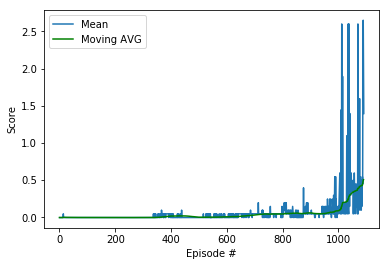

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(mean_scores)+1), mean_scores, label='Mean')
plt.plot(np.arange(len(moving_avgs)), moving_avgs, c='g', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [ ]:
agent = Agent(state_size=24, action_size=2, random_seed=2)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

for _ in range(5):
    while True:
        actions = agent.act(states)                        # select actions from loaded model agent
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
print('Total score: {}'.format(np.mean(scores)))